# Week 10: Advanced Financial Engineering (42108)

## Subject: ***Counterparty Risk (Credit Value Adjustments)***

### Date: 19/04-2023

## Packages

In [77]:
import numpy as np
import scipy.io
import pandas as pd
import numpy.matlib
import matplotlib.pyplot as plt 
from scipy.stats import norm
from scipy import interpolate
from math import sqrt, exp

## 1)

### 1.1)

We start by reading the data into a dictionary.

In [89]:
R = 0.4

JUL07 = {'s':{1:16,3:29,5:45,7:50,10:58},
         'avg_hazard':{1:0.0027,3:0.0048,5:0.0075,7:0.0083,10:0.0097},
         'hazard':{1:0.0662,3:0.0525,5:0.0462,7:0.0430,10:0.0400},
         'q':{1:np.nan,3:np.nan,5:np.nan,7:np.nan,10:np.nan},
         'EE':{1:np.nan,3:np.nan,5:np.nan,7:np.nan,10:np.nan},
         'DF':{1:np.nan,3:np.nan,5:np.nan,7:np.nan,10:np.nan}}

JUN08 = {'s':{1:397,3:315,5:277,7:258,10:240},
         'avg_hazard':{1:0.0662,3:0.0525,5:0.0462,7:0.0430,10:0.0400},
         'hazard':{1:0.0662,3:0.0525,5:0.0462,7:0.0430,10:0.0400},
         'q':{1:np.nan,3:np.nan,5:np.nan,7:np.nan,10:np.nan},
         'EE':{1:np.nan,3:np.nan,5:np.nan,7:np.nan,10:np.nan},
         'DF':{1:np.nan,3:np.nan,5:np.nan,7:np.nan,10:np.nan}}

Then we need to calculate the probability of default using the average hazard rate. The difference between the cumulative probability functions of default will yield us the answer.

Notice that $q_{i}$ is the probability of default (PD) between $[t_{i-1};t_{i}]$.

We start by defining the piecewise-linear hazard rate function. This is convenient when we want to know the probability of default at all times - not just where we have data.

In [137]:
def hazard(t, period = 'JUL07'):
    
    # Define the sample times for the spreads
    sample_times = np.array([1,3,5,7,10])
    
    if t <= sample_times[0]:
        if period == 'JUL07':
            return(np.array(list(JUL07['avg_hazard'].values()))[1])
        if period == 'JUN08':
            return(np.array(list(JUN08['avg_hazard'].values()))[1])
    else:
        # Then we get the end points of the interval
        t_start = sample_times[sample_times <= t][-1]
        if len(sample_times[sample_times > t_start]) == 0:
            if period == 'JUL07':
                return(JUL07['avg_hazard'][t_start]*t_start)
            if period == 'JUN08':
                return(JUN08['avg_hazard'][t_start]*t_start)
        else:
            t_end = sample_times[sample_times > t_start][0]

        # Return hazard rate for the intervals
        if period == 'JUL07':
            return((JUL07['avg_hazard'][t_end]*t_end - JUL07['avg_hazard'][t_start]*t_start)/(t_end - t_start))

        if period == 'JUN08':
            return((JUN08['avg_hazard'][t_end]*t_end - JUN08['avg_hazard'][t_start]*t_start)/(t_end - t_start))

def Q(t, period = 'JUL07'):
    
    if period == 'JUL07':
        return(1 - np.exp(-hazard(t, period = 'JUL07') * t))
    if period == 'JUN08':
        return(1 - np.exp(-hazard(t, period = 'JUN08') * t))
    
def PD(t1, t2, period='JUL07'):
    
    if period == 'JUL07':
        return(Q(t2) - Q(t1))
    if period == 'JUL07':
        return(Q(t2, period = 'JUN08') - Q(t1, period = 'JUN08'))

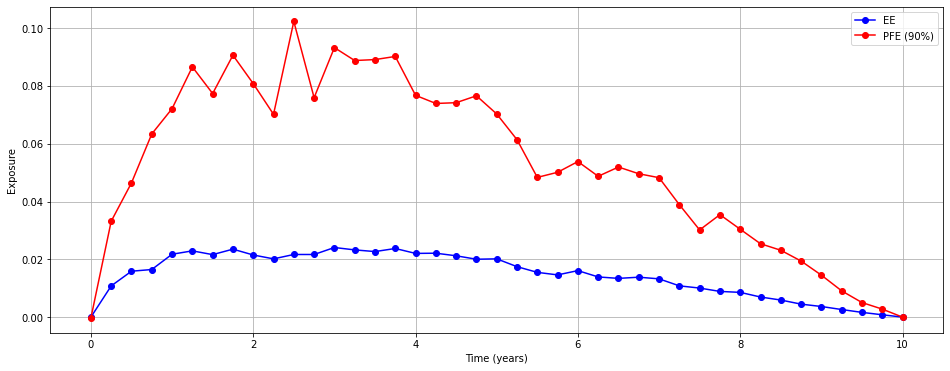

In [138]:
# Input data
SpotRate = 0.002;
k = 0.1;
theta = 0.02;
Vol = 0.01;
SwapRate = 0.0077; # pick your self or calculate at-market rate
TimeSteps = numpy.arange(0, 10.25, 0.25);
T = len(TimeSteps)-1;
PFE = []

K = 100

# This part is run many times
InterestRate = np.empty((T,K))
FloatingLeg = np.empty((T,K))
FixedLeg = np.empty((T,K))
SwapMtM = np.empty((T,K))

for m in range(K):
    # Simulate interest rates
    InterestRate[0,m] = SpotRate
    for i in range(1,T):
        InterestRate[i,m] = InterestRate[i-1,m] + k*(theta-InterestRate[i-1,m])*(TimeSteps[i]-TimeSteps[i-1])+np.random.standard_normal()*np.sqrt((TimeSteps[i]-TimeSteps[i-1]))*Vol

    B = (1-np.exp(-k*TimeSteps[1:T+1]))/k
    A = np.exp(((B-TimeSteps[1:T+1])*(k**2*theta-Vol**2/2))/k**2-(Vol**2*B**2/(4*k)))

    # Calculate discount factors to value swap
    DiscountFactors = np.full([T, T], np.nan)

    for i in range(T):
        DiscountFactors[:(T-i),i] = A[i]*np.exp(-InterestRate[:(T-i),m]*np.transpose(B[i]))

    FloatingLeg[:,m] = np.ones(T)-np.fliplr(DiscountFactors).diagonal()
    FixedLeg[:,m] = SwapRate*0.25*np.nansum(DiscountFactors, axis = 1)
    SwapMtM[:,m] = (FixedLeg[:,m]-FloatingLeg[:,m])
    
# Calculate exposure and 90% peak exposure
Exposure = SwapMtM*(SwapMtM>0);
EE = Exposure.mean(axis = 1)

for i in range(T):
    PFE.append(np.quantile(SwapMtM[i,:],0.9))
    
plt.figure(figsize = (16,6))
plt.plot(TimeSteps, np.append(EE, 0), '-bo', label = 'EE')
plt.plot(TimeSteps, np.append(PFE, 0), '-ro', label = 'PFE (90%)')
plt.xlabel('Time (years)')
plt.ylabel('Exposure')
plt.legend()
plt.grid()
plt.show()

In [139]:
alpha = 1
CVA_07 = alpha * (1 - R) * sum(DiscountFactors[0,i-1]*EE[i-1]*PD(TimeSteps[i],TimeSteps[i-1]) for i in range(1,len(TimeSteps)))

In [141]:
alpha = 1
CVA_08 = alpha * (1 - R) * sum(DiscountFactors[0,i-1]*EE[i-1]*PD(TimeSteps[i],TimeSteps[i-1], period = 'JUN08') for i in range(1,len(TimeSteps)))

TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'